# In this notebook I will create 3d interpolations of the mach probe measurements.

I look at 3 campaigns.
1. mach_probe_plane_campaign_1 of z=0.419m with z and y direction measurements.
2. mach_probe_plane_campaign_2 of z=0.302m with z direction measurements.
3. mach_probe_line_campaign_1 of z=0.249m x=-0.005m with z direction measurements
There are several single point campaigns that I ignore for now.

Most measurements of the mach_probe_line_campaign return nan when processed by mach probe code. Maybe they are not good measurements or there is an error in my code. Most likely they have several zero crossings which makes the saturation current ratio nan.

The goal for the remaining measurements is to determine the maximum extent of a bounding cube of the interpolation grid that has no nan points. Interpolated points can evalulate to nan when they require extrapolation outside the convex hull of measurement points or interpolation from measurement points that evaluate to nan.

# Imports

In [19]:
import numpy as np
from scipy.interpolate import griddata

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')

import sys

In [20]:
from pyvisfile.vtk import write_structured_grid
from pytools.obj_array import make_obj_array

In [22]:
sys.path.append('../../read_from_sql/')
import read_from_sql
sys.path.append('/Users/vonderlinden2/rsx_analysis/mach_probe_analysis')
sys.path.append('/Users/vonderlinden2/rsx_analysis/time_alignment/source')
import absolute_times as at
import ion_current_to_mach_number as ic_to_mach


import structured_3d_vtk as struc_3d
reload(struc_3d)

<module 'structured_3d_vtk' from 'structured_3d_vtk.pyc'>

# Define constants

In [23]:
database = '/Users/vonderlinden2/rsx_analysis/shots_database/source/shots.db'
table = 'Shots'

In [24]:
z_direction_1, z_direction_2 = 0, 180
y_direction_1, y_direction_2 = 90, 270

In [25]:
angle_signs = {0: 1,
               180: -1,
               90: -1,
               0: 1}

## Set minimum spectral density

In [26]:
min_spectral_density = 1.6e-8

# Collect suitable shots from the plane_campaign_1, plane_campaign_2, and line_campaign 

## plane_campaign_1

In [27]:
condition_z_0416 = ("campaigns = 'mach_probe_plane_campaign_1'"
                    " AND fiducial_pre_crowbar_gyration_spectral_density > "
                    + str(min_spectral_density) +
                    " AND mach_signals_exist = 1"
                    " AND (mach_orientation = " + str(z_direction_1) +
                    " OR mach_orientation = " + str(z_direction_2) + ")")

condition_y_0416 = ("campaigns = 'mach_probe_plane_campaign_1'"
                    " AND fiducial_pre_crowbar_gyration_spectral_density > "
                    + str(min_spectral_density) +
                    " AND mach_signals_exist = 1"
                    " AND (mach_orientation = " + str(y_direction_1) +
                    " OR mach_orientation = " + str(y_direction_2) + ")")

In [28]:
cursor, connection = read_from_sql.cursor_with_rows(condition_z_0416,
                                                    database,
                                                    table)
z_0416_shots = cursor.fetchall()
cursor.close()
connection.close()

In [29]:
cursor, connection = read_from_sql.cursor_with_rows(condition_y_0416,
                                                    database,
                                                    table)
y_0416_shots = cursor.fetchall()
cursor.close()
connection.close()

## plane_campaign_2

In [30]:
condition_z_302 = ("campaigns = 'mach_probe_plane_campaign_2'"
                   " AND fiducial_pre_crowbar_gyration_spectral_density > "
                   + str(min_spectral_density) +
                   " AND mach_signals_exist = 1"
                   " AND (mach_orientation = " + str(z_direction_1) +
                   " OR mach_orientation = " + str(z_direction_2) + ")")

cursor, connection = read_from_sql.cursor_with_rows(condition_z_302,
                                                    database,
                                                    table)
z_0302_shots = cursor.fetchall()
cursor.close()
connection.close()

## line_campaign_1

In [31]:
condition_z_0249 = ("campaigns = 'mach_probe_line_campaign_1'"
                    " AND fiducial_pre_crowbar_gyration_spectral_density > "
                    + str(min_spectral_density) +
                    " AND mach_signals_exist = 1"
                    " AND (mach_orientation = " + str(z_direction_1) +
                    " OR mach_orientation = " + str(z_direction_2) + ")")

cursor, connection = read_from_sql.cursor_with_rows(condition_z_0249,
                                                    database,
                                                    table)

z_0249_shots = cursor.fetchall()
cursor.close()
connection.close()

# Run Mach probe analysis on the measurements

In [32]:
def times_to_indexes(time, times):
    r"""
    Return the index closest to a time.
    """
    indexes = np.searchsorted(time, times)
    for i, index in enumerate(indexes):
        indexes[i] = (index-1 +
                      np.argmin([np.abs(times[i] - time[index - 1]),
                                 np.abs(times[i] - time[index]),
                                 np.abs(times[i] - time[index + 1])]))
    return indexes

In [33]:
def run_mach_analysis(shots, time_points, angle_signs):
    r"""
    Return mach number as a function of time for a iterator of shot database sql rows.
    """
    mach_out, x_out, y_out, z_out = [], [], [], []
    for shot in shots:

        shot_number = shot['shot']
        times = at.absolute_times(shot_number, shot, [],
                                  number_of_delays=time_points)
        (mach, time,
         r_background_std,
         l_background_std) = ic_to_mach.mach_number(shot_number, 
                                                    mach_r_node_name=shot['mach_r_node'],
                                                    mach_l_node_name=shot['mach_l_node'])
        mach = mach*angle_signs[shot['mach_orientation']]
        indexes = times_to_indexes(time, times)
        mach_out.append(mach[indexes])
        x_out.append(shot['mach_x'])
        y_out.append(shot['mach_y'])
        z_out.append(shot['mach_z'])
    x_out = np.asarray(x_out)
    y_out = np.asarray(y_out)
    z_out = np.asarray(z_out)
    mach_out = np.asarray(mach_out)
    mach_out = np.swapaxes(mach_out, 0, 1)
    measurements = {'a_out': mach_out,
                    'x_out': x_out,
                    'y_out': y_out,
                    'z_out': z_out}
    return measurements

In [34]:
mach_z_0416_measurements = run_mach_analysis(z_0416_shots,
                                             21, 
                                             angle_signs) 
mach_y_0416_measurements = run_mach_analysis(y_0416_shots,
                                             21, 
                                             angle_signs)
mach_z_0302_measurements = run_mach_analysis(z_0302_shots,
                                             21, 
                                             angle_signs)
mach_z_0249_measurements = run_mach_analysis(z_0249_shots,
                                             21, 
                                             angle_signs)

# Start interpolating

## set interpolation bounds

In [35]:
spatial_increment = 0.001

x_min, x_max = -0.023, 0.024
y_min, y_max = -0.02, 0.03
z_min, z_max = 0.416, 0.416
mach_y_0416_bounds = ((x_min, x_max), (y_min, y_max), (z_min, z_max)) 

x_min, x_max = -0.023, 0.024
y_min, y_max = -0.02, 0.03
z_min, z_max = 0.302, 0.416
mach_z_plane_bounds = ((x_min, x_max), (y_min, y_max), (z_min, z_max)) 

x_min, x_max = -0.005, -0.005
y_min, y_max = -0.005, 0.03
z_min, z_max = 0.249, 0.416
mach_z_line_bounds = ((x_min, x_max), (y_min, y_max), (z_min, z_max)) 

## First interpolate the y values on plane 4

In [36]:
scalars_y = []

for time_point in xrange(21):
    print 'time_point %i' % time_point
    (mach_y_0416_points, 
     mach_y_0416_values) = struc_3d.read_points_from_measurement_dict({0.416: mach_y_0416_measurements}, 
                                                                      time_point, 
                                                                      [0.416])
    to_remove = []
    for i, value in enumerate(mach_y_0416_values):
        if np.isnan(value):
            to_remove.append(i)
    mach_y_0416_values = np.delete(mach_y_0416_values, to_remove)
    mach_y_0416_points = np.delete(mach_y_0416_points, to_remove, 0)
    
    grid_points, sizes = struc_3d.bounded_grid(mach_y_0416_bounds, spatial_increment)
    
    grid_points = np.delete(grid_points, 2, 1)
    mach_y_0416_points = np.delete(mach_y_0416_points, 2, 1)
    
    mach_y_0416_interpolated = struc_3d.interpolate_scalar(grid_points, mach_y_0416_points, 
                                                           mach_y_0416_values)
    assert np.sum(np.isnan(mach_y_0416_interpolated)) == 0
    
    
    mach_y_0416_grid_points = np.insert(grid_points, 2, np.ones((grid_points.shape[0]))*0.416, axis=1)
    
    vtk_grid = struc_3d.prepare_mesh(mach_y_0416_grid_points, sizes)
    mach_y_0416_vtk_scalar = struc_3d.prepare_scalar(mach_y_0416_interpolated, sizes)
    
    scalars_y.append(mach_y_0416_vtk_scalar)
    
    output_path = '../output/2016-06-14/'
    write_structured_grid(output_path + 
                          'mach_y_' + str(time_point).zfill(4) + '.vts', vtk_grid, point_data=[('mach_y', 
                                                                                                mach_y_0416_vtk_scalar)])

time_point 0


RuntimeError: output file '../output/2016-06-14/mach_y_0000.vts' already exists

In [37]:
grid_points.shape

(2350, 2)

# Adjust bounds

In [967]:
spatial_increment = 0.001

x_min, x_max = -0.027, 0.022
y_min, y_max = -0.02, 0.03
z_min, z_max = 0.416, 0.416
mach_y_0416_bounds = ((x_min, x_max), (y_min, y_max), (z_min, z_max)) 

x_min, x_max = -0.027, 0.022
y_min, y_max = -0.02, 0.03
z_min, z_max = 0.302, 0.416

mach_z_plane_bounds = ((x_min, x_max), (y_min, y_max), (z_min, z_max)) 

## Investigate the distrbution of nans in interpolated grid of mach_y and mach_z

In [968]:
scalars = []

for time_point in xrange(21):
    print 'time_point %i' % time_point
    (mach_z_plane_points, 
     mach_z_plane_values) = struc_3d.read_points_from_measurement_dict({0.416: mach_z_0416_measurements,
                                                                        0.302: mach_z_0302_measurements},
                                                                       time_point, 
                                                                       [0.302, 0.416])
    
    for i, value in enumerate(mach_z_plane_values):
        if np.isnan(value):
            to_remove.append(i)
    mach_z_plane_values = np.delete(mach_z_plane_values, to_remove)
    mach_z_plane_points = np.delete(mach_z_plane_points, to_remove, 0)
    
    
    grid_points, sizes = struc_3d.bounded_grid(mach_z_plane_bounds, spatial_increment)
    mach_z_plane_interpolated = struc_3d.interpolate_scalar(grid_points, mach_z_plane_points, 
                                                            mach_z_plane_values)
    
    vtk_grid = struc_3d.prepare_mesh(grid_points, sizes) 
    scalar = struc_3d.prepare_scalar(mach_z_plane_interpolated, sizes)
    scalars.append(scalar)
scalars = np.asarray(scalars)

scalars_y = []

for time_point in xrange(21):
    print 'time_point %i' % time_point
    (mach_y_0416_points, 
     mach_y_0416_values) = struc_3d.read_points_from_measurement_dict({0.416: mach_y_0416_measurements}, 
                                                                      time_point, 
                                                                      [0.416])
    to_remove = []
    for i, value in enumerate(mach_y_0416_values):
        if np.isnan(value):
            to_remove.append(i)
    mach_y_0416_values = np.delete(mach_y_0416_values, to_remove)
    mach_y_0416_points = np.delete(mach_y_0416_points, to_remove, 0)
    
    grid_points, sizes = struc_3d.bounded_grid(mach_y_0416_bounds, spatial_increment)
    
    grid_points = np.delete(grid_points, 2, 1)
    mach_y_0416_points = np.delete(mach_y_0416_points, 2, 1)
    
    mach_y_0416_interpolated = struc_3d.interpolate_scalar(grid_points, mach_y_0416_points, 
                                                           mach_y_0416_values)
    #assert np.sum(np.isnan(mach_y_0416_interpolated)) == 0
    
    
    mach_y_0416_grid_points = np.insert(grid_points, 2, np.ones((grid_points.shape[0]))*0.416, axis=1)
    
    vtk_grid = struc_3d.prepare_mesh(mach_y_0416_grid_points, sizes)
    mach_y_0416_vtk_scalar = struc_3d.prepare_scalar(mach_y_0416_interpolated, sizes)
    
    scalars_y.append(mach_y_0416_vtk_scalar)
    

time_point 0
grid (279300, 3)
m points (490, 3)
values (490,)
time_point 1
grid (279300, 3)
m points (480, 3)
values (480,)
time_point 2
grid (279300, 3)
m points (471, 3)
values (471,)
time_point 3
grid (279300, 3)
m points (465, 3)
values (465,)
time_point 4
grid (279300, 3)
m points (463, 3)
values (463,)
time_point 5
grid (279300, 3)
m points (459, 3)
values (459,)
time_point 6
grid (279300, 3)
m points (457, 3)
values (457,)
time_point 7
grid (279300, 3)
m points (451, 3)
values (451,)
time_point 8
grid (279300, 3)
m points (446, 3)
values (446,)
time_point 9
grid (279300, 3)
m points (443, 3)
values (443,)
time_point 10
grid (279300, 3)
m points (432, 3)
values (432,)
time_point 11
grid (279300, 3)
m points (423, 3)
values (423,)
time_point 12
grid (279300, 3)
m points (416, 3)
values (416,)
time_point 13
grid (279300, 3)
m points (409, 3)
values (409,)
time_point 14
grid (279300, 3)
m points (399, 3)
values (399,)
time_point 15
grid (279300, 3)
m points (392, 3)
values (392,)
ti

In [969]:
print np.sum(np.isnan(scalars))
print np.sum(np.isnan(scalars_y))

0
0


In [945]:
is_nan = np.where(np.isnan(scalars))
not_nan = np.where(np.invert(np.isnan(scalars)))

In [851]:
heatmap_scalars = np.array(scalars)
heatmap_scalars[is_nan] = 1
heatmap_scalars[not_nan] = 0

In [852]:
vtk_grid.shape

(3, 10, 10, 23)

In [853]:
is_nan_for_grid = np.where(np.isnan(scalars[0, 0, :, :, :]))

In [854]:
vtk_grid[0][is_nan_for_grid]

array([], dtype=float64)

In [855]:
heatmap_scalars.shape

(21, 1, 10, 10, 23)

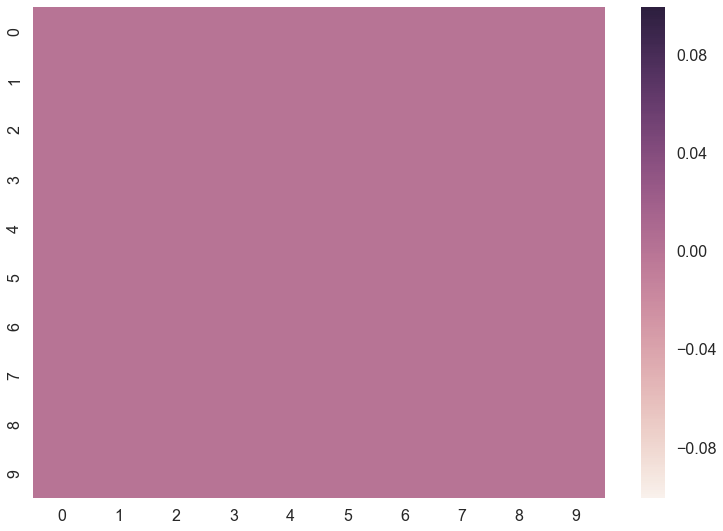

In [856]:
sns.heatmap(heatmap_scalars[0, 0, :, :, 0])

In [857]:
np.sum(np.isnan(scalars))

0

In [858]:
for time_point in xrange(21):
    print 'time_point %i' % time_point
    (mach_z_plane_points, 
     mach_z_plane_values) = struc_3d.read_points_from_measurement_dict({0.416: mach_z_0416_measurements,
                                                                        0.302: mach_z_0302_measurements},
                                                                       time_point, 
                                                                       [0.302, 0.416])
    
    for i, value in enumerate(mach_z_plane_values):
        if np.isnan(value):
            to_remove.append(i)
    mach_z_plane_values = np.delete(mach_z_plane_values, to_remove)
    mach_z_plane_points = np.delete(mach_z_plane_points, to_remove, 0)
    
    
    grid_points, sizes = struc_3d.bounded_grid(mach_z_plane_bounds, spatial_increment)
    mach_z_plane_interpolated = struc_3d.interpolate_scalar(grid_points, mach_z_plane_points, 
                                                            mach_z_plane_values)
    

    assert np.sum(np.isnan(mach_z_plane_interpolated)) == 0
    
    mach_vector = np.zeros((3, mach_z_plane_interpolated.size))
    plane_0416 = np.where(grid_points[:, 2] == 0.416)[0]
    mach_vector[1][plane_0416] = mach_y_0416_interpolated  
    mach_vector[2] = mach_z_plane_interpolated
    
    vtk_grid = struc_3d.prepare_mesh(grid_points, sizes)
    mach_vtk_vector = struc_3d.prepare_vector(mach_vector, sizes)
    
    output_path = '../output/2016-06-14/'
    write_structured_grid(output_path + 
                          'mach' + str(time_point).zfill(4) + '.vts', vtk_grid, point_data=[('mach', 
                                                                                            mach_vtk_vector)])

time_point 0
time_point 1
time_point 2
time_point 3
time_point 4
time_point 5
time_point 6
time_point 7
time_point 8
time_point 9
time_point 10
time_point 11
time_point 12
time_point 13
time_point 14
time_point 15
time_point 16
time_point 17
time_point 18
time_point 19
time_point 20


# Interpolate the z values on a line on plane 1, 2, & 4

### Most measurement points return Mach number nan. The line campaign is not that useful. 

In [859]:
for time_point in xrange(21):
    print 'time_point %i' % time_point
    (mach_z_line_points, 
     mach_z_line_values) = struc_3d.read_points_from_measurement_dict({0.416: mach_z_0416_measurements,
                                                                       0.302: mach_z_0302_measurements,
                                                                       0.249: mach_z_0249_measurements}, 
                                                                      time_point, 
                                                                      [0.249, 0.302, 0.416])
    
    for i, value in enumerate(mach_z_line_values):
        if np.isnan(value):
            to_remove.append(i)
    mach_z_line_values = np.delete(mach_z_line_values, to_remove)
    mach_z_line_points = np.delete(mach_z_line_points, to_remove, 0)
    
    grid_points, sizes = struc_3d.bounded_grid(mach_z_line_bounds, spatial_increment)
    mach_z_line_interpolated = struc_3d.interpolate_scalar(grid_points, mach_z_line_points, 
                                                           mach_z_line_values)

    
    #assert np.sum(np.isnan(mach_z_line_interpolated)) == 0
    
    vtk_grid = struc_3d.prepare_mesh(grid_points, sizes)
    mach_z_line_vtk = struc_3d.prepare_scalar(mach_z_line_interpolated, sizes)

time_point 0
time_point 1
time_point 2
time_point 3
time_point 4
time_point 5
time_point 6
time_point 7
time_point 8
time_point 9
time_point 10
time_point 11
time_point 12
time_point 13
time_point 14
time_point 15
time_point 16
time_point 17
time_point 18
time_point 19
time_point 20


In [549]:
not_nan = np.invert(np.isnan(mach_z_0249_measurements['a_out'][0]))

In [550]:
mach_z_0249_measurements['y_out'][not_nan]

array([], dtype=float64)

In [495]:
mach_z_line_points

array([[ 0.028,  0.015,  0.302],
       [ 0.028,  0.04 ,  0.302],
       [ 0.028,  0.045,  0.302],
       [ 0.028, -0.015,  0.302],
       [ 0.028, -0.02 ,  0.302],
       [ 0.028, -0.025,  0.302],
       [ 0.028, -0.03 ,  0.302],
       [ 0.028, -0.035,  0.302],
       [ 0.028, -0.04 ,  0.302],
       [ 0.028, -0.045,  0.302],
       [ 0.028, -0.05 ,  0.302],
       [ 0.028, -0.05 ,  0.302],
       [ 0.028, -0.05 ,  0.302],
       [ 0.028, -0.05 ,  0.302],
       [ 0.021,  0.03 ,  0.302],
       [ 0.021,  0.035,  0.302],
       [ 0.021,  0.04 ,  0.302],
       [ 0.021, -0.005,  0.302],
       [ 0.021, -0.01 ,  0.302],
       [ 0.021, -0.015,  0.302],
       [ 0.021, -0.03 ,  0.302],
       [ 0.021, -0.045,  0.302],
       [ 0.021, -0.05 ,  0.302],
       [ 0.021, -0.05 ,  0.302],
       [ 0.021, -0.05 ,  0.302],
       [ 0.021, -0.05 ,  0.302],
       [ 0.014,  0.005,  0.302],
       [ 0.014,  0.01 ,  0.302],
       [ 0.014,  0.015,  0.302],
       [ 0.014,  0.025,  0.302],
       [ 0

In [485]:
grid_points

array([[-0.005     , -0.005     ,  0.249     ],
       [-0.005     , -0.005     ,  0.25406061],
       [-0.005     , -0.005     ,  0.25912121],
       [-0.005     , -0.005     ,  0.26418182],
       [-0.005     , -0.005     ,  0.26924242],
       [-0.005     , -0.005     ,  0.27430303],
       [-0.005     , -0.005     ,  0.27936364],
       [-0.005     , -0.005     ,  0.28442424],
       [-0.005     , -0.005     ,  0.28948485],
       [-0.005     , -0.005     ,  0.29454545],
       [-0.005     , -0.005     ,  0.29960606],
       [-0.005     , -0.005     ,  0.30466667],
       [-0.005     , -0.005     ,  0.30972727],
       [-0.005     , -0.005     ,  0.31478788],
       [-0.005     , -0.005     ,  0.31984848],
       [-0.005     , -0.005     ,  0.32490909],
       [-0.005     , -0.005     ,  0.3299697 ],
       [-0.005     , -0.005     ,  0.3350303 ],
       [-0.005     , -0.005     ,  0.34009091],
       [-0.005     , -0.005     ,  0.34515152],
       [-0.005     , -0.005     ,  0.350

In [486]:
is_nan = np.where(np.isnan(mach_z_line_vtk))
not_nan = np.where(np.invert(np.isnan(mach_z_line_vtk)))

In [487]:
heatmap = np.array(mach_z_line_vtk)
heatmap[is_nan] = 1
heatmap[not_nan] = 0

In [488]:
heatmap.shape

(1, 1, 7, 34)

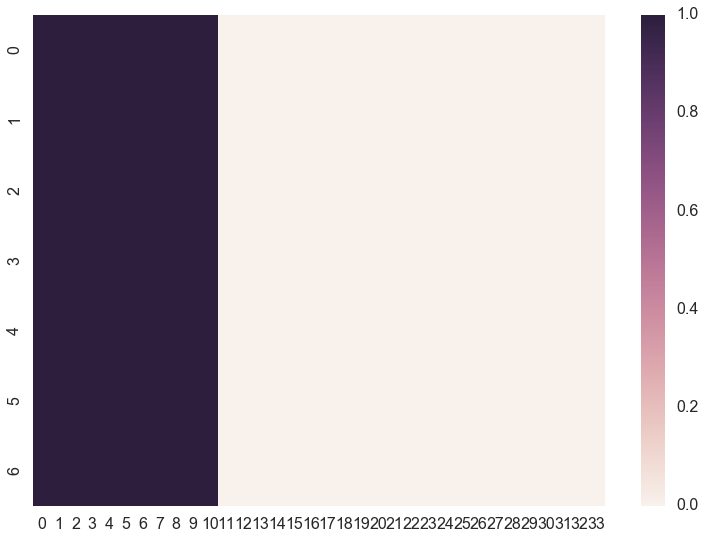

In [489]:
sns.heatmap(heatmap[0,0])